In [ ]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression as LR
import scipy

%matplotlib inline

SEED = 133742069
np.random.seed(SEED)


def load_wines(classes=2, columns=2):
  raw_wine_ds = datasets.load_wine()
  class_filter = raw_wine_ds.target < classes

  X = raw_wine_ds.data[class_filter][:,:columns]
  y = raw_wine_ds.target[class_filter]

  return train_test_split(X, y, test_size=0.33, random_state=42)


def load_iris(classes=2, columns=2):
  raw_wine_ds = datasets.load_iris()
  class_filter = raw_wine_ds.target < classes

  X = raw_wine_ds.data[class_filter][:,:columns]
  y = raw_wine_ds.target[class_filter]

  _, unique_indices = np.unique(X, return_index=True, axis=0)

  return train_test_split(X[unique_indices], y[unique_indices], test_size=0.33, random_state=42)


def load_gaussian_dataset(n, means, variance):
  X = np.concatenate([
                      np.random.multivariate_normal(m, variance * np.eye(2), n)
                      for m in means
                     ])

  y = np.concatenate([np.repeat(i,n) for i in range(len(means))])

  return train_test_split(X, y, test_size=0.10, random_state=42)

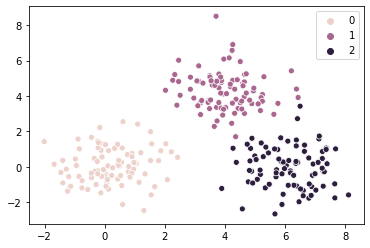

In [ ]:
X_train, X_test, y_train, y_test = load_gaussian_dataset(100, [[0,0], [4,4], [6,0]], 1)

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)


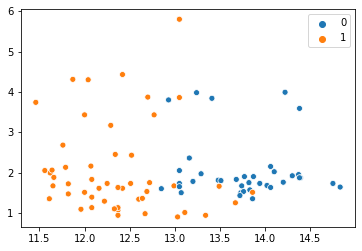

In [ ]:
X_train, X_test, y_train, y_test = load_wines(classes=2, columns=2)

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)

In [ ]:
class NormalDist():
    def __init__(self, mu, l):
        self.mu = mu
        self.l = l

        
def generate_normal_variable(class_size, dists):
    return np.array([
        np.random.normal(d.mu, d.l, class_size)
        for d in dists
    ])


def random_normal_distribution():
    return NormalDist(np.random.rand(), np.random.rand())


def generate_data(class_size, class_count, variable_count):
    return (
        np.concatenate([
            generate_normal_variable(
                class_size,
                [random_normal_distribution() for _ in range(class_count)]
            )
            for _ in range(variable_count)
        ]).reshape(variable_count, class_size * class_count).T,
        np.concatenate([[c] * class_size for c in range(class_count)])
    )


class Data():
    def __init__(self, class_size, class_count, variable_count):
        self.X, self.y = generate_data(
            class_size = class_size,
            class_count = class_count,
            variable_count = variable_count
        )
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=0
        )


0.7627118644067796


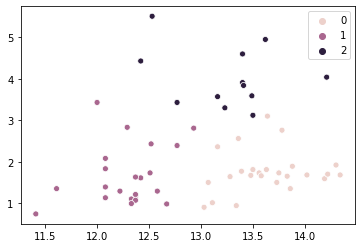

In [ ]:
class CuadradosMinimos():
    
    def int_to_cannonical_vector(self, n, length):
        res = np.zeros(length)
        res[n] = 1
        return res


    def array_to_cannonical_vectors(self, x):
        cs = np.unique(x)
        nums = np.arange(len(cs))
        d = dict(zip(cs,nums))
        return np.concatenate([
            self.int_to_cannonical_vector(d[k], len(cs))
            for k in x
        ]).reshape(-1, len(cs))
    
    
    def fit(self, X, T):
        afin = np.ones((X.shape[0], X.shape[1] + 1))
        afin[:,1:] = X
        X = afin
        Y = self.array_to_cannonical_vectors(T)
        B = X.T @ Y
        A = X.T @ X
        self.W = np.linalg.solve(A,B)


    def predict(self, X):
        afin = np.ones((X.shape[0], X.shape[1] + 1))
        afin[:,1:] = X
        X = afin
        y = self.W.T @ X.T
        return np.argmax(y, axis=0)


X_train, X_test, y_train, y_test = load_wines(classes=3, columns=2)
#X_train, X_test, y_train, y_test = load_gaussian_dataset(100, [[0,0], [4,4], [6,0]], 1)

cuadradosMinimos = CuadradosMinimos()
cuadradosMinimos.fit(X_train, y_train)

predictions = cuadradosMinimos.predict(X_test)

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions)

print(accuracy_score(y_test, predictions))
#print(cuadradosMinimos.W)

0.9767441860465116


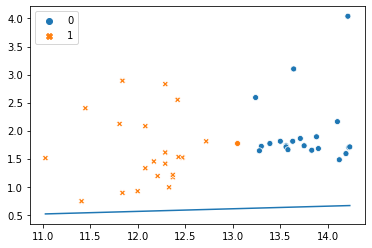

In [ ]:
# Ej 2: Fisher para dos clases

class Fisher2Classes:
  def scatter_matrix(self, X, m):
    return np.sum([np.outer((x - m), (x - m).T) for x in X], axis=0)

  def fit(self, X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]

    self.prior0 = X0.shape[0] / X.shape[0]
    self.prior1 = X1.shape[0] / X.shape[0]

    m0 = np.mean(X0, axis=0)
    m1 = np.mean(X1, axis=0)

    S0 = self.scatter_matrix(X0, m0)
    S1 = self.scatter_matrix(X1, m1)
    Sw = S1 + S0

    self.w = np.linalg.solve(Sw, m0-m1)

    x0_proy = X0 @ self.w
    x1_proy = X1 @ self.w

    self.mu0 = np.mean(x0_proy)
    self.std0 = np.std(x0_proy)

    self.mu1 = np.mean(x1_proy)
    self.std1 = np.std(x1_proy)

    self.std = np.std(X @ self.w)


  def predict(self, X):
    X_proy = X @ self.w

    posteriors0 = norm.pdf(X_proy, loc=self.mu0, scale=self.std0) * self.prior0
    posteriors1 = norm.pdf(X_proy, loc=self.mu1, scale=self.std1) * self.prior1

    return (posteriors0 < posteriors1).astype(np.int)


X_train, X_test, y_train, y_test = load_wines(classes=2, columns=2)

fisher2Classes = Fisher2Classes()
fisher2Classes.fit(X_train, y_train)

predictions = fisher2Classes.predict(X_test)

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions, style=y_test)

line_x = np.arange(start=np.min(X_test[:,0]), stop=np.max(X_test[:,0]), step=0.01)
line_y = line_x * fisher2Classes.w[1] / fisher2Classes.w[0]

sns.lineplot(x=line_x, y=line_y)

print(accuracy_score(y_test, predictions))

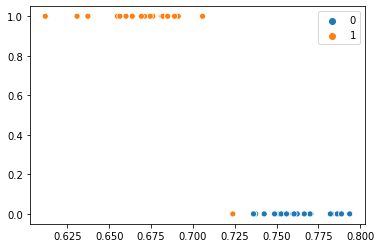

In [ ]:
sns.scatterplot(x=X_test @ fisher2Classes.w, y=y_test, hue=predictions)

In [ ]:
# Ej 2: Fisher para K clases

class FisherKClasses:
  def scatter_matrix(self, X, m):
    return np.sum([np.outer((x - m), (x - m).T) for x in X], axis=0)

  def X_class(self, c):
    return self.X[self.y == c]

  def calculate_sb(self, means, ns):
    mean = np.mean(self.X, axis=0)
    return np.sum([ns[c] * np.outer((means[c] - mean), (means[c] - mean).T) for c in range(0, self.k)], axis=0)

  def calculate_sw(self, means):
    scatter_matrices = [self.scatter_matrix(self.X_class(c), means[c]) for c in range(0, self.k)]
    return np.sum(scatter_matrices, axis=0)

  def fit(self, X, y):
    self.X = X
    self.y = y
    self.k = len(np.unique(y))

    self.priors = [self.X_class(c).shape[0] / X.shape[0] for c in range(0, self.k)]
    assert np.isclose(np.sum(self.priors), 1), "priors sum 1"
    
    # tamaños de las clases
    ns = [self.X_class(c).shape[0] for c in range(0, self.k)]
    assert np.sum(ns) == X.shape[0]

    means = [np.mean(self.X_class(c), axis=0) / ns[c] for c in range(0, self.k)]
    Sw = self.calculate_sw(means)
    Sb = self.calculate_sb(means, ns)

    #scipy.linalg.eigh?
    #eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) @ Sb)  
    eigenvalues, eigenvectors = scipy.linalg.eigh(Sb, Sw)
    indices = np.argsort(-np.abs(eigenvalues))[0:self.k-1]

    self.W = eigenvectors[:,indices]
    #print(eigenvalues[indices])

    self.class_means = []
    self.class_covs = []

    for c in range(0, self.k): 
      Xs_proy = self.X_class(c) @ self.W
      self.class_means.append(np.mean(Xs_proy, axis=0))
      self.class_covs.append(np.cov(Xs_proy.T))


  def predict(self, X):
    X_proy = X @ self.W

    predictions = []
    for i in range(X_proy.shape[0]):
      X_posteriors = [multivariate_normal.pdf(X_proy[i], mean=self.class_means[c], cov=self.class_covs[c]) * self.priors[c] 
                      for c in range(0, self.k)]

      predictions.append(np.argmax(X_posteriors))

    return np.array(predictions)

X_train, X_test, y_train, y_test = load_wines(classes=3, columns=3)

fisherKClasses = FisherKClasses()
fisherKClasses.fit(X_train, y_train)

predictions = fisherKClasses.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8135593220338984


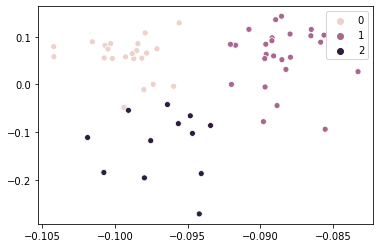

In [ ]:
proys = X_test @ fisherKClasses.W
sns.scatterplot(x=proys[:,0], y=proys[:,1], hue=predictions)

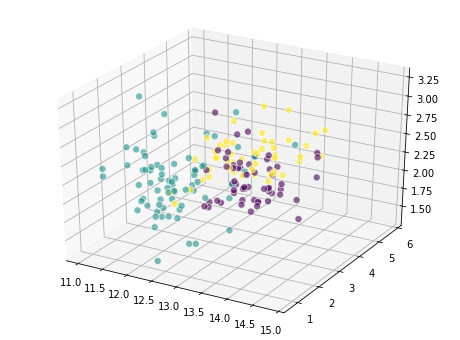

In [ ]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],  s=50, alpha=0.6, edgecolors='w', c=y)
fig.show()

In [ ]:
def sigma(a):
    return 1 / (1 + np.exp(-a))

def phi_id(row):
    return np.insert(row, 0, 1)

class RegresionLogistica():

    def generate_matrix_phi(self, X):
        phi = np.apply_along_axis(self.phi_func, 1, X)
        return phi / max(np.apply_along_axis(lambda row: np.linalg.norm(row), 1, X))
    

    def generate_y(self, phi, w):
        return sigma(phi @ w)

                
    def generate_matrix_R(self, phi, w):
        y = self.generate_y(phi, w)
        return np.diag(y * (1 - y))
                

    def update_w(self, w, phi, R):
        y = self.generate_y(phi, w)
        z = phi @ w - np.sqrt(R) @ (y - self.T)
        phi_times_R = phi.T @ R
        return np.linalg.solve(phi_times_R @ phi, phi_times_R @ z)
                
    
    def fit(self, X, T, phi_func = phi_id, niter = 10000):
        self.T = T
        self.phi_func = phi_func
        phi = self.generate_matrix_phi(X)
        # w = np.zeros(X.shape[1] + 1)
        #print(phi)
        w = np.ones(phi.shape[1])
        diffs = []
        for i in range(niter):
            w_new = self.update_w(w, phi, self.generate_matrix_R(phi, w))
            diffs.append(np.linalg.norm(np.abs(w - w_new)))
            w = w_new
        self.w = w
        
        #print(np.array(diffs)[-42:])

    def predict(self, X):
        phi = self.generate_matrix_phi(X)
        y = self.w.T @ phi.T
        return np.where(sigma(y) < .5, 0, 1)

1.0


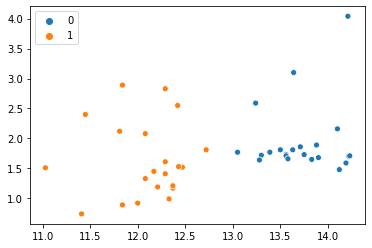

In [ ]:
X_train, X_test, y_train, y_test = load_wines(classes=2, columns=2)

rl = RegresionLogistica()
rl.fit(X_train, y_train)

predictions = rl.predict(X_test)

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions)

print(accuracy_score(y_test, predictions))

0.9534883720930233


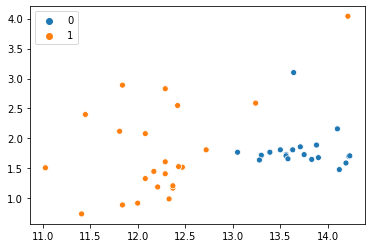

In [ ]:
def phi_eliptic(row):
  x1, x2 = row[0], row[1]
  x = np.array([1, x1, x2, x1**2, x1*x2, x2**2])

  # podriamos probar normalizar por la maxima norma del dataset
  return x #/ np.linalg.norm(x)


data = Data(150, 2, 2)
X_train, X_test, y_train, y_test = load_wines(classes=2, columns=2)
#data.X_train, data.X_test, data.y_train, data.y_test
#load_wines(classes=2, columns=2)

rl = RegresionLogistica()
rl.fit(X_train, y_train, phi_eliptic)

predictions = rl.predict(X_test)

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions)

print(accuracy_score(y_test, predictions))

0.9696969696969697


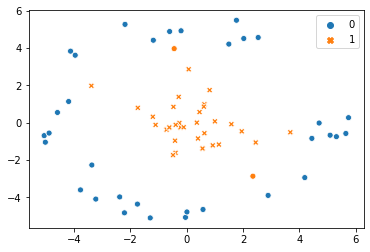

In [ ]:
radio = 5

def polares_a_punto(angulo, radio):
    return [radio*np.cos(angulo), radio*np.sin(angulo)]

def generar_puntos_en_anillo(cantidad, radio=5):
    angulos = np.random.uniform(0, 2*np.pi, cantidad)
    radios = np.random.normal(loc=radio, scale=radio/10, size=cantidad)
    return np.array([
        polares_a_punto(ang, rad)
        for (ang, rad) in zip(angulos, radios)
    ])

def generar_puntos_internos(cantidad, radio):
    return np.random.multivariate_normal(mean=[0,0], cov=radio * np.eye(2), size=cantidad)

cant_por_clase = 100
X0 = generar_puntos_en_anillo(cant_por_clase)
y0 = np.repeat(0, cant_por_clase)

X1 = generar_puntos_internos(cant_por_clase, 1.5)
y1 = np.repeat(1, cant_por_clase)

X = np.concatenate([X0, X1])
y = np.concatenate([y0, y1])

#sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rl = RegresionLogistica()
rl.fit(X_train, y_train, phi_eliptic)

predictions = rl.predict(X_test)

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions, style=y_test)

print(accuracy_score(y_test, predictions))